In [1]:
# Initial setup. Just run this cell once.
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Information Theory Primer

Here we'll explore a few basic concepts from [information theory](https://en.wikipedia.org/wiki/Information_theory) that are particularly relevant for this course. Information theory is a fairly broad subject, founded in the 1940s by [Claude Shannon](https://en.wikipedia.org/wiki/Claude_Shannon), that gives a mathematical foundation for quantifying the communication of information. Shannon's original paper included, for example, the idea of the [bit](https://en.wikipedia.org/wiki/Bit), the minimal unit of information.

It turned out that an information theoretic perspective is particularly convenient for understanding machine learning. So let's review the following concepts, which will appear throughout the course:

* Mutual Information
* Entropy
* Cross-Entropy
* KL Divergence

You may have encountered several of these concepts in machine learning classes you've taken.  For similar reasons, they are important in NLP. We'll discuss them throughout the semester as they appear, but it is worth quickly going through the definitions once up front so they are fresh in your mind!

Answer the questions below as you encounter them. There are a lot of questions, but almost all answers should be very short (less than one line).

### Pointwise Mutual Information

[Pointwise Mutual Information (PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information) is a measure of how much knowing one outcome tells you about another.

For example:  if I tell you it's raining, you'd probably guess it's cloudy.  But if I told you one die rolled 6, you couldn't guess what the other die rolled. Applied to language, if you mention the word "rain", I learn that you're more likely to also say "wet" or "umbrella" in the same context.

The formula for PMI is as follows:

$$\text{PMI}(x, y) = \log_2\frac{p(x, y)}{p(x)\ p(y)}$$

In short, it measures the chance two outcomes tend to co-occur (the numerator) relative to the chance they would co-occur if they were independent events (the denominator). The $\log_2$ makes it easier to reason about very large or very small values of this ratio - and let's us give it a unit: bits. We'll explain more about this below.

"Point-wise" refers to the fact that we're picking single outcomes for "x" and "y" (i.e. x = "raining", y = "cloudy").  Without the point-wise (i.e. just ["mutual information"](https://en.wikipedia.org/wiki/Mutual_information)) refers to the average (expected value) point-wise mutual information between all possible assignments to x and y.

If $X$ and $Y$ are independent, then $\text{PMI}(x,y) = 0$ for all values of $x$ and $y$.

### Entropy

[Entropy (Shannon entropy)](https://en.wikipedia.org/wiki/Shannon_entropy) is a notion of how "uncertain" the outcome of some experiment is.  The more uncertain - or the more spread out the distribution - the higher the entropy. *(Aside: some of you may have encountered "entropy" in a thermodynamics class.  Entropy as we're defining it here is conceptually similar - a notion of the amount of disorder in a system, and the concepts are closely related.)*

Mathematically, for a (discrete) random variable $X$,

$$\text{Entropy}(X) = H(X) = -\Sigma_x\ p(x) \log_2 p(x)$$

*(We take $0 \times log_2(0) = 0$, although in the "real world" probabilities are rarely equal to 0.)*

Or, in English: imagine you have some probability distribution over a discrete set of events $X$.  Loop over each event and take the product of the probability of that event and the base-2 log of the probability.  Or, put another way, find the expected value $E[-\log_2 p(x)]$ for this probability distribution.

You have to admit, it's a bit of an odd calculation if you've never seen it before.  Why $\log_2$?  Why is there a negative sign?

Before we explain exactly what's going on, let's play with the equation a little.

Let's compute the entropy of the result of a coin flip whose probability of heads is $P(\text{heads}) = p$

Fill in the code for BinaryEntropy below to calculate the entropy given a probability of heads, p.

In [2]:
def XLogX(x):
    """Returns x * log2(x)."""
    return np.nan_to_num(x * np.log2(x))

def BinaryEntropy(p):
    """Compute the entropy of a coin toss with P(heads) = p."""
    #### YOUR CODE HERE ####
    # Hint: Make sure you sum over all possible outcomes (heads & tails)!
    entropy = -(XLogX(p)+XLogX(1-p))
    return entropy
    #### END YOUR CODE ####

# Let's try running it for p = 0.  This means the coin always comes up "tails".
# We expect that the entropy of this is 0 as there is no uncertainty about the outcome.
assert 0.0 == BinaryEntropy(0)

# We expect p = 0.5 to be as uncertain as it gets.  There's no good prior guess
# as to which of heads or tails the coin is going to come down on.
# As a result, we expect this to be bigger than p=0 above, but also bigger than any
# other value of p.
assert BinaryEntropy(0.5) > BinaryEntropy(0)
assert BinaryEntropy(0.5) > BinaryEntropy(0.49)
assert BinaryEntropy(0.5) > BinaryEntropy(0.51)

# As it turns out the entropy at p=0.5 is 1.0.
assert 1.0 == BinaryEntropy(0.5)

print(BinaryEntropy(0.75))

0.8112781244591328


Text(0, 0.5, 'Entropy $H_2(X)$')

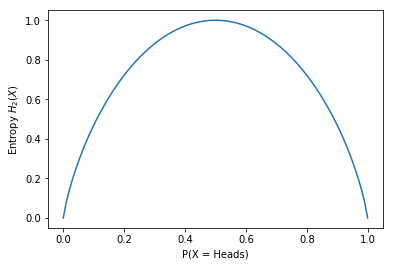

In [3]:
# Poking at a couple of individual values is interesting, but we can also simply plot
# entropy for all possibly values of P(H).
# As expected, the curve is maximum at p = 0.5 when the outcome is most uncertain
# and decreases to 0 as either heads or tails becomes a certainty.
p_of_heads = np.arange(0, 1.01, 0.01);
plt.plot(p_of_heads, BinaryEntropy(p_of_heads))
plt.xlabel('P(X = Heads)'); plt.ylabel('Entropy $H_2(X)$')

For a binary variable $x \in \{0,1\}$ like our coin flip, the maximum entropy happens to be $H(X) = 1.0$. But don't be fooled by this - entropy is only bounded below (by 0), and can be arbitrarily large. We'll see this below.

### Interpreting Entropy: Sending Messages

Imagine you want to send one of two messages to your friend, message **A** or message **B**. Imagine sending **A** and **B** were equally likely: $P(A) = P(B) = 0.5$, so you decide on the following code:

```
A -> 0
B -> 1
```
Since there are only two options, a single bit will suffice. Note that 1 bit is equal to:

$$ \begin{eqnarray}
1\ \text{bit} = -\log_2\frac{1}{2} & = & -\frac{1}{2}\log_2\frac{1}{2} - \frac{1}{2}\log_2\frac{1}{2} \\
& = & - P(A) \log_2 P(A) - P(B) \log_2 P(B) \\
& = & H_2(0.5) \end{eqnarray}$$

...which is exactly the entropy of the distribution of messages! Now imagine you want to send one of three messages $m \sim M$:

- **A** with $P(A) = 0.5$
- **B** with $P(B) = 0.25$
- **C** with $P(C) = 0.25$

Since **A** is sent more often, we might want to give it a shorter code to save bandwidth. So we could try:

```
A -> 0
B -> 10
C -> 11
```

*Aside: note that this code is uniquely decodable left-to-right! This is known as a [Prefix code](https://en.wikipedia.org/wiki/Prefix_code).*

How many bits does this code use, on average? Let's see:

$$ 0.5\times1\ \text{bit} + 0.25\times2\ \text{bits} + 0.25\times2\ \text{bits} = 1.5\ \text{bits} $$

Which we note is once again equal to the entropy of the distribution:

$$ H(M) = -0.5\log_2(0.5) - 0.25\log_2(0.25) - 0.25\log_2(0.25) = 1.5\ \text{bits}$$

It turns out that this code is optimal, and in general the entropy $H(M)$ is the fewest number of bits on average that _any_ code can use to send messages from the distribution $M$.\* If we take bits to mean information, then the entropy is the _minimum_ amount of information needed (on average) to uniquely encode messages $m \sim M$!

As such, we often think of entropy as the **information content** of the distribution. It can be a counterintuitive way of thinking about it: a uniform distribution has high entropy, but doesn't tell us very much about what the value of a sample will be! But it means that when we do get a sample, it may contain a lot of information indeed.

We often also think of entropy as how "spread out" a distribution is. In the extreme case, a distribution like:
- **A** with $P(A) = 1.0$
- **B** with $P(B) = 0.0$
- **C** with $P(C) = 0.0$
would require zero bits to specify, since all the mass is at one point A, so we already know what any message will be! So the entropy here would be 0. But if the mass is more spread out - like a uniform distribution, or, in continuous space, a very broad Gaussian - then many messages become equally likely, and so we need more bits (on average) to describe one.

\* This result is known as [Shannon's source coding theorem](https://en.wikipedia.org/wiki/Shannon%27s_source_coding_theorem), which states that an optimal code can be constructed by using $- \log_2 p(m)$ bits for each specific message $m$.

### Cross Entropy

What if we get the code wrong? Suppose we have a finite sample of messages (introducing some _variance_), and we train a machine learning model (introducing some _bias_) to estimate the true probabilities. Let's call the predicted distribution $Q(X)$.

Now we generate a code based on $Q(X)$, and use it to encode real messages (which come from $P(X)$). How many bits do we use, on average?

If we design an optimal code for $Q$, we use $-\log_2 Q(x)$ bits for message $x$. Then we average this over $x \sim P$ to get:

$$ \text{CE}(P,Q) = \sum_{x} - P(x) \log_2 Q(x) = \mathrm{E}_{x \sim P(x)}\left[ -\log_2 Q(x) \right] $$

Since we "crossed" the code from $Q$ and used it on $P$, this is known as the [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy). Note that $ \text{CE}(P,Q) \ge H(P) $, because we know that the code trained on $Q$ can't possibly be better than the optimal code on $P$ itself! 

In the form above, this is the most commonly used loss function in machine learning. In unsupervised learning (density estimation), we use it exactly as-is, with $x$ as the data. In supervised learning, we take the random variable to be the label $y$, and take our distributions to be conditional ones: $P(y\ |\ x)$ and $Q(y\ |\ x)$:
$$ \text{CE}(P,Q)(x) = \sum_{y'} -P(y'\ |\ x) \log_2 Q(y'\ |\ x) $$
It's common to average over $x$ and to approximate $P(y\ |\ x)$ with discrete samples $(x,y)$ from a test set $T$, in which case we get:

$$ \text{CE}(P,Q) 
\approx \frac{1}{|T|} \sum_{(x,y) \in T} \sum_{y'} -\mathbb{1}[y = y'] \log_2 Q(y'\ |\ x) 
= \frac{1}{|T|} \sum_{(x,y) \in T} -\log_2 Q(y\ |\ x) 
$$

We'll commonly also write this using natural logarithms, but you can always convert between the two by the formula $ \log_2(x) = \log_2(e) \cdot \ln(x) $.

## KL Divergence

We learned that we use the word "cross-entropy" to refer to the average number of bits we need if we design our code with $Q(X)$ (i.e. our model) in mind but end up sending with probability $P(X)$ (i.e. the test set).  Similarly, "entropy" is the average bits we need if we design with the right distribution in mind.

We don't yet have a name for the difference between these quantities (i.e. the size of the *penalty* for using the wrong distribution to optimize our code).  That difference is known as the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), or KL divergence for short.

It is a measure of how different two probability distributions are.  The more $Q$ differs from $P$, the worse the penalty would be, and thus the higher the KL divergence.

That is,
$$ D_{KL}(P\ ||\ Q) = CE(P, Q) - H(P)$$

From a machine learning perspective, the KL divergence measures the "avoidable" error - when our model is perfect (i.e. the *distribution* $\hat{P}(y\ |\ x_i) = P(y\ |\ x_i)$, the KL divergence goes to zero. In general, the cross-entropy loss - and prediction accuracy - will not be zero, but will be equal to the entropy $H(P)$. This "unavoidable" error is the [Bayes error rate](https://en.wikipedia.org/wiki/Bayes_error_rate) for the underlying task.

**Important note:** we're taking the true distribution $y_i = P(y\ |\ x_i) = [1, 0, 0, 0]$ in this example to be one-hot (i.e. all mass on one value). This is different from the one-hot encoding we use for training labels, which are _observations_ (single values) _sampled_ from some true distribution $y_i^\text{obs} \sim P(y\ |\ x_i)$. In that case, one-hot encoding is just a convenient shortcut. In general - and particularly in NLP - we'll have some label uncertainty, and the true distribution $P(y\ |\ x_i)$ will be spread among potentially many possibilities.

One final observation:  cross-entropy is not symmetric (think about how $P$ and $Q$ appear in the formula to understand why).  As a result KL Divergence isn't symmetric either (if you want to prove this to yourself substitute in for CE and E in the equation above and simplify).  So while KL divergence is a measure of similarity, it's useful to keep in mind that $D_{KL}(P\ ||\ Q) \ne D_{KL}(Q\ ||\ P)$.

# Exercises

_Don't forget to put your answers in the "answers" file, not here!_

### A. Pointwise Mutual Information

1. If $P(\text{rainy}, \text{cloudy})= 0.2$, $P(\text{rainy}) = 0.2$ and $P(\text{cloudy}) = 0.8$, what is $\text{PMI}(\text{rainy}, \text{cloudy})$?
2. Imagine $x$ is some word in a sentence, and $y$ is the next word in the sentence.  Imagine $P(\text{washington})=0.003$, $P(\text{post}) = 0.01$, and $P(\text{washington}, \text{post}) = 0.002$.  What is $\text{PMI}(\text{washington}, \text{post})$?

### B. Entropy

1. What if you had 128 messages, sending each with a probability of 1/128?  What's the expected number of bits?  What is the entropy of this distribution? What about 1024 messages each with probability 1/1024?
2. Consider the following sentences, and a hypothetical distribution over words that could fill in the blank:  
`(A) "How much wood could a _____ chuck if a woodchuck could chuck wood?"`  
`(B) "Hi, my name is _____."`  
Which blank has higher entropy, A or B?
3. Consider two normal (Gaussian) distributions: (A) $x \sim \mathcal{N}(0,1)$ and (B) $y \sim \mathcal{N}(7,0.5)$. Which variable has higher entropy?

### C. Cross-Entropy and KL Divergence

For the following questions, imagine you have a classification problem over four labels, $\{0,1,2,3\}$.  For some example $x_i$, the correct label is class $0$.  That is, our true distribution is $y_i = P(y\ |\ x_i) = [1, 0, 0, 0]$.  Your model generates this probability distribution over the classes: $\hat{y}_i = \hat{P}(y\ |\ x_i) = [0.7, 0.2, 0.05, 0.05]$.

1.  Compute $\text{CrossEntropy}(y, \hat{y})$.
2.  Find $D_{KL}(y\ ||\ \hat{y})$.  Either perform the computation, or recognize the entropy(y) and that cross entropy = entropy + $D_{KL}$.
3.  When the label vector is "one-hot" as it is in this case (i.e. only a single category has any probability mass), do you actually need to compute everything?
4.  What would $\text{CrossEntropy}(y, \hat{y})$ be if your model assigned all probability mass to the correct class (class 0)? (i.e. if $\hat{y}_i = y_i = [1, 0, 0, 0]$)
5.  What if the model assigned all probability mass to class 1 instead?
6.  What if the model assigned $\frac{1}{3}$ to each of classes 1, 2, and 3, and zero to class 0?